In [1]:
import h5py
import astropy.units as u 
import numpy as np

import jabble.dataset
import jabble.loss
import jabble.model

In [2]:
data = h5py.File('data/datatest1.h5','r')

In [3]:
data['parameters'].keys()
epoches = data['data']['flux'].shape[0]

In [4]:
masks = np.zeros(data['data']['flux'].shape,dtype=bool)
wave = np.repeat(np.array(data['data']['wave'])[np.newaxis,:],epoches,axis=0) * u.Angstrom
flux = np.array(data['data']['flux'])
ferr = np.array(data['data']['ferr'])

In [5]:
wob_data = jabble.dataset.WobbleDataset(wave,flux,ferr,masks)

In [6]:
epoches = flux.shape[0]

In [7]:
print(epoches)

30


In [8]:
def get_berv(times,observatory_name,ra,dec):
    obj = coord.SkyCoord(ra,dec)
    loc = coord.EarthLocation.of_site(observatory_name)
    bc  = obj.radial_velocity_correction(obstime=times,location=loc).to(u.km/u.s)
    return bc

In [9]:
import astropy.time as at
import astropy.coordinates as coord

In [10]:
print(data['theory']['times'][0])

2022-09-28T08:23:22.345


In [11]:
times = at.Time([data['theory']['times'][ii] for ii in range(epoches)],format='isot') 
obs = data['parameters']['obs'][()]
ra = data['parameters']['ra'][()]*u.degree
dec = data['parameters']['dec'][()]*u.degree
period = 10*u.day # known but should be saved in parameters

In [12]:
print(obs,ra,dec)

APO 240.79098149028 deg -56.684988093815655 deg


In [13]:
init_vels = get_berv(times,obs,ra,dec)
init_shifts = jabble.dataset.shifts(init_vels)

In [14]:
rvs = data['parameters']['rvs']

In [15]:
import matplotlib.pyplot as plt

In [16]:
rvs = np.array(rvs)*u.km/u.s

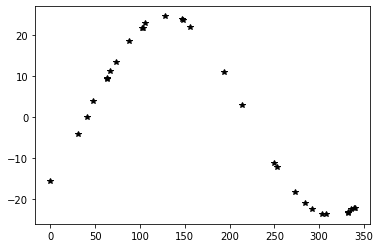

In [17]:
dts = times-at.Time.now()
# period over a year bc I didn't give the stellar model any
# drifting velocity in simulacra
plt.plot((times - min(times)).to(u.day).value,rvs,'*k')

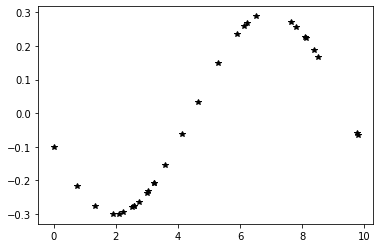

In [18]:
plt.plot((times - min(times)).to(u.day).value % period.value,rvs-init_vels,'*k')

the mitochondrdia is the powehouse of the cell

In [19]:
loss = jabble.loss.ChiSquare()

In [20]:
import astropy.constants as const
resolution = data['theory']['resolution'][()]
vel_padding = 500 * u.m/u.s

In [21]:
x_grid = jabble.model.create_x_grid(wob_data.xs,vel_padding,resolution)#step=jabble.dataset.shifts(const.c.to(u.km/u.s)/resolution))
stellar_model = jabble.model.CompositeModel([jabble.model.ShiftingModel(init_shifts),jabble.model.JaxLinear(x_grid)])
stellar_model.fit(1)

In [22]:
maxiter = 4
res = stellar_model.optimize(loss,wob_data,maxiter)

[ Value: 2.21e+14 ]
[ Value: 2.52e+15 ]
[ Value: 1.92e+14 ]
[ Value: 1.60e+14 ]
[ Value: 1.02e+14 ]
[ Value: 9.02e+13 ]


In [23]:
vel_width = 500 * u.km/u.s

In [ ]:
velocity_kern = np.arange(-vel_width.to(u.km/u.s).value,vel_width.to(u.km/u.s).value,const.c.to(u.km/u.s).value/resolution)*u.km/u.s
velocity_grid = np.add.outer(init_vels,velocity_kern)

shift_grid = jabble.dataset.shifts(velocity_grid)
loss_array = stellar_model[0].grid_search(shift_grid,loss,stellar_model,wob_data)
# loss_array    = jabble.dataset.get_loss_array(shift_grid,stellar_model[1],wob_data.xs,wob_data.ys,wob_data.yerr,loss)
# # stacked = np.stack((shift_grid,loss_array))
# # wobble_model.save(loss_name,stacked)
# x_min, x_vals, y_vals, polynomials   = jabble.dataset.get_parabolic_min(loss_array,shift_grid,return_all=True)
# stellar_model[0].p = x_min
# wobble_model.save(x_name,x_min)

In [ ]:
velocity_kern.shape

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
epoch_idx = 0
plt.plot(shift_grid[epoch_idx,:],loss_array[epoch_idx,:],'*k')

In [ ]:
stellar_model.fit(0)
maxiter = 32
res,callback = stellar_model.optimize(loss,wob_data,maxiter)

In [ ]:
final_vels = jabble.dataset.velocityfromshift(stellar_model[0].p)

In [ ]:
plt.plot((times - min(times)).to(u.day).value % period.value,rvs-init_vels,'*k')
plt.plot((times - min(times)).to(u.day).value % period.value,final_vels-init_vels,'*r')
plt.ylim(-1,1)